# Goal of EDA

The goal of this EDA notebook is to simply get a general look at our data to understand what we're working with. We may find some interesting quirks that may negatively affect our model later on down the line, or help us engineer better features to use. Certain key steps include what each feature represents, getting an idea of what values may be missing, and earning how imbalanced our predicted classes are so our model may be adjusted accordingly.

In [1]:
import importlib
import JeffUtils
importlib.reload(JeffUtils)

<module 'JeffUtils' from 'C:\\Users\\j3ff1\\Documents\\School Work\\MLProjects\\TelecomChurnAnalysis\\JeffUtils.py'>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import scipy
import re
from typing import Union, List

In [3]:
pd.set_option('display.max_columns', None)

we set a predetermined random seed so our experiment results can be easily replicated 

In [4]:
RANDOM_SEED = 1337

# Loading Raw Data

Load in data from: https://www.kaggle.com/datasets/abhinav89/telecom-customer?resource=download

In [5]:
raw_data = pd.read_csv('telecomChurn.zip')

the data has 100 features to work with, and 100,000 data points

In [6]:
raw_data.shape

(100000, 100)

In [7]:
raw_data.head(5)

,rev_Mean,mou_Mean,totmrc_Mean,da_Mean,ovrmou_Mean,ovrrev_Mean,vceovr_Mean,datovr_Mean,roam_Mean,change_mou,change_rev,drop_vce_Mean,drop_dat_Mean,blck_vce_Mean,blck_dat_Mean,unan_vce_Mean,unan_dat_Mean,plcd_vce_Mean,plcd_dat_Mean,recv_vce_Mean,recv_sms_Mean,comp_vce_Mean,comp_dat_Mean,custcare_Mean,ccrndmou_Mean,cc_mou_Mean,inonemin_Mean,threeway_Mean,mou_cvce_Mean,mou_cdat_Mean,mou_rvce_Mean,owylis_vce_Mean,mouowylisv_Mean,iwylis_vce_Mean,mouiwylisv_Mean,peak_vce_Mean,peak_dat_Mean,mou_peav_Mean,mou_pead_Mean,opk_vce_Mean,opk_dat_Mean,mou_opkv_Mean,mou_opkd_Mean,drop_blk_Mean,attempt_Mean,complete_Mean,callfwdv_Mean,callwait_Mean,churn,months,uniqsubs,actvsubs,new_cell,crclscod,asl_flag,totcalls,totmou,totrev,adjrev,adjmou,adjqty,avgrev,avgmou,avgqty,avg3mou,avg3qty,avg3rev,avg6mou,avg6qty,avg6rev,prizm_social_one,area,dualband,refurb_new,hnd_price,phones,models,hnd_webcap,truck,rv,ownrent,lor,dwlltype,marital,adults,infobase,income,numbcars,HHstatin,dwllsize,forgntvl,ethnic,kid0_2,kid3_5,kid6_10,kid11_15,kid16_17,creditcd,eqpdays,Customer_ID
0,23.9975,219.25,22.500,0.2475,0.00,0.0,0.0,0.0,0.0,-157.25,-18.9975,0.666667,0.0,0.666667,0.0,6.333333,0.0,52.333333,0.0,42.333333,0.0,45.000000,0.0,0.000000,0.000000,0.000000,18.000000,0.000000,90.643333,0.0,97.176667,0.000000,0.000000,0.000000,0.000000,58.000000,0.0,132.600000,0.0,24.000000,0.0,55.220000,0.0,1.333333,52.333333,45.000000,0.0,0.333333,1,61,2,1,U,A,N,1652,4228.00000,1504.62,1453.44,4085.00,1602,29.66,83.37,32.69,272,116,30,322.0,136.0,38.0,S,NORTHWEST/ROCKY MOUNTAIN AREA,Y,N,149.98999,2.0,2.0,WCMB,0.0,0.0,O,15.0,S,S,1.0,M,4.0,3.0,C,A,0.0,N,U,U,U,U,U,Y,361.0,1000001
1,57.4925,482.75,37.425,0.2475,22.75,9.1,9.1,0.0,0.0,532.25,50.9875,8.333333,0.0,1.000000,0.0,61.333333,0.0,263.333333,0.0,69.000000,0.0,193.333333,0.0,1.666667,6.333333,5.463333,53.000000,0.333333,189.396667,0.0,55.280000,46.333333,24.216667,6.333333,3.696667,83.666667,0.0,75.333333,0.0,157.000000,0.0,169.343333,0.0,9.333333,263.333333,193.333333,0.0,5.666667,0,56,1,1,N,EA,N,14654,26400.00000,2851.68,2833.88,26367.00,14624,51.53,479.40,265.89,305,158,40,477.0,275.0,48.0,U,CHICAGO AREA,N,N,NaN,7.0,6.0,WC,1.0,1.0,NaN,1.0,S,S,1.0,M,5.0,1.0,C,A,0.0,Z,U,U,U,U,U,Y,240.0,1000002
2,16.9900,10.25,16.990,0.0000,0.00,0.0,0.0,0.0,0.0,-4.25,0.0000,0.333333,0.0,0.000000,0.0,2.666667,0.0,9.000000,0.0,0.333333,0.0,6.000000,0.0,0.000000,0.000000,0.000000,0.333333,0.000000,5.426667,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.0,5.193333,0.0,1.000000,0.0,0.233333,0.0,0.333333,9.000000,6.000000,0.0,0.000000,1,58,1,1,Y,C,N,7903,24385.05333,2155.91,1934.47,24303.05,7888,34.54,433.98,140.86,12,7,17,11.0,6.0,17.0,S,GREAT LAKES AREA,N,N,29.98999,2.0,1.0,NaN,0.0,0.0,O,7.0,S,M,2.0,M,5.0,2.0,C,A,0.0,N,U,Y,U,U,U,Y,1504.0,1000003
3,38.0000,7.50,38.000,0.0000,0.00,0.0,0.0,0.0,0.0,-1.50,0.0000,0.000000,0.0,0.000000,0.0,0.000000,0.0,3.666667,0.0,1.333333,0.0,3.666667,0.0,0.000000,0.000000,0.000000,1.333333,0.000000,8.410000,0.0,0.413333,0.333333,0.256667,0.000000,0.000000,1.333333,0.0,3.380000,0.0,3.666667,0.0,5.450000,0.0,0.000000,3.666667,3.666667,0.0,0.000000,0,60,1,1,Y,B,N,1502,3065.00000,2000.90,1941.81,3035.00,1479,40.45,63.23,30.81,8,3,38,50.0,25.0,40.0,T,CHICAGO AREA,N,N,29.98999,1.0,1.0,NaN,0.0,0.0,NaN,6.0,M,M,4.0,M,6.0,1.0,C,D,0.0,U,Y,U,U,U,U,Y,1812.0,1000004
4,55.2300,570.50,71.980,0.0000,0.00,0.0,0.0,0.0,0.0,38.50,0.0000,9.666667,0.0,0.666667,0.0,77.000000,0.0,222.333333,0.0,94.666667,0.0,137.000000,0.0,8.666667,15.000000,11.076667,66.000000,0.000000,285.233333,0.0,106.330000,14.666667,10.816667,0.666667,0.366667,97.333333,0.0,173.476667,0.0,90.333333,0.0,218.086667,0.0,10.333333,222.333333,137.000000,0.0,0.000000,0,57,1,1,Y,A,N,4485,14028.00000,2181.12,2166.48,13965.00,4452,38.69,249.38,79.50,558,191,55,586.0,196.0,80.0,U,NEW ENGLAND AREA,Y,N,149.98999,6.0,4.0,WCMB,0.0,0.0,R,5.0,M,S,1.0,M,6.0,1.0,C,O,0.0,I,U,U,U,U,U,Y,434.0,1000005


The data description claims that Customer ID is a primary key for this table (no duplicate customer data). We first verify that this is true, and if so, set it as the index

In [6]:
if raw_data.shape[0] == raw_data['Customer_ID'].nunique():
    raw_data = raw_data.set_index('Customer_ID')
    print('Customer ID is a primary key')

Customer ID is a primary key


Cast all column names to lower case and order them alphabetically for ease of use

In [7]:
raw_data.columns = map(str.lower,raw_data.columns)
raw_data = raw_data[np.sort(raw_data.columns)]

## Handling column descriptions

Since there is literally a hundred columns in this dataset, we may want to group similar columns together and analyze them group by group for a easier time. We just want a quick look so we won't use any complicated state of the art NLP methods, and stick with the tried and true, quick and dirty method of tfidf+kmeans clustering.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import gensim
import spacy

### read-in column descriptions

column descriptions are scraped straight from the kaggle website via beautifulsoup

In [9]:
col_desc = pd.read_json('columnDescriptions.json',orient='index')[0].rename('col_desc').to_frame()

In [10]:
#set it to all lower case like we did column names in raw data
col_desc.index = col_desc.index.str.lower()
#pull out customer_id since it is just a primary key
col_desc = col_desc.drop(['customer_id'])
#pull out churn since it is our target variable
col_desc = col_desc.drop(['churn'])

In [11]:
col_desc.head(5)

,col_desc
rev_mean,Mean monthly revenue (charge amount)
mou_mean,Mean number of monthly minutes of use
totmrc_mean,Mean total monthly recurring charge
da_mean,Mean number of directory assisted calls
ovrmou_mean,Mean overage minutes of use


### Preprocess column descriptions

In [11]:
#Remove stop words
col_desc['clean_desc'] = (
    col_desc['col_desc']
    .apply(gensim.parsing.preprocessing.remove_stopwords)
)

#Remove characters that are not decimals,
#not letters, and not white space
col_desc['clean_desc'] = (
    col_desc['clean_desc']
    .str.replace('[^a-zA-Z0-9_ ]','')
)
#Replace double whitespace with single space
#created from operation above
col_desc['clean_desc'] = (
    col_desc['clean_desc']
    .str.replace('  ',' ')
)

In [12]:
nlp = spacy.load('en_core_web_sm')

In [13]:
#Tokenize words in the cleaned description and lemmatize them
col_desc['tokenized'] = col_desc['clean_desc'].apply(lambda x: [token.lemma_ for token in nlp(x)])
#Join lemmatized tokens back into single string for ease of use
col_desc['lemmatized'] = col_desc['tokenized'].apply(lambda x: ' '.join(x))

In [17]:
col_desc.head(5)

,col_desc,clean_desc,tokenized,lemmatized
rev_mean,Mean monthly revenue (charge amount),Mean monthly revenue charge amount,"[mean, monthly, revenue, charge, amount]",mean monthly revenue charge amount
mou_mean,Mean number of monthly minutes of use,Mean number monthly minutes use,"[mean, number, monthly, minute, use]",mean number monthly minute use
totmrc_mean,Mean total monthly recurring charge,Mean total monthly recurring charge,"[mean, total, monthly, recur, charge]",mean total monthly recur charge
da_mean,Mean number of directory assisted calls,Mean number directory assisted calls,"[mean, number, directory, assist, call]",mean number directory assist call
ovrmou_mean,Mean overage minutes of use,Mean overage minutes use,"[mean, overage, minute, use]",mean overage minute use


### Tfidf

Transform our column descriptions into a tf-idf matrix so that we have numerical data to work with

In [14]:
tfidf = TfidfVectorizer()
tfidfMatrix = tfidf.fit_transform(col_desc['lemmatized'])

### kmeans grouping

We'll try to cluster similar columns together via K-Means since its quic and dirty.

In [15]:
#import utility functions
from JeffUtils import graph_cluster_wc, graph_elbow

We try values from 5-15 clusters for the number of clusters parameter of K-Means. Any less than 5 would likely not yield much separation between each cluster. Meanwhile, any more clusters than 15 is a little much to go through by hand, hence would make this entire process kind of redundant. 

In [60]:
kmeans = []
for i in range(5,16):
    km = KMeans(n_clusters=i,random_state=RANDOM_SEED)
    km.fit_predict(tfidfMatrix.toarray())
    kmeans.append((i,km.inertia_))

Then determine the elbow of the loss. The elbow is calculated via the second derivative of the loss curve at every point, and the point with the highest second derivative is chosen as our parameter for the number of clusters. From the graph below, we see that the optimal number of clusters would be 6 clusters.

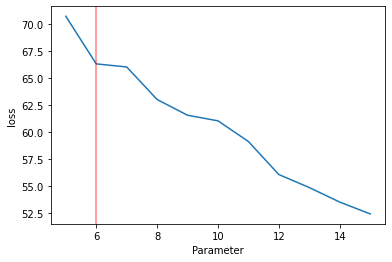

In [61]:
loss = pd.DataFrame(kmeans)[1].rename('loss')
#since the min number of clusters tested started at 5
loss.index = loss.index+5
#graph loss at every point and return optimal point
elbow = graph_elbow(loss) 

we'll use the determined elbow as our n_cluster parameter to run kmeans

In [18]:
kmeans = KMeans(n_clusters=elbow,random_state=RANDOM_SEED)
col_desc['kmeans_class'] = kmeans.fit_predict(tfidfMatrix.toarray())

In [19]:
from JeffUtils import graph_all_cluster_wc

We now graph the 5 most common words appearing in each cluster, with the x axis representing the percentage of column descriptions in the cluster that contains the word in question. Some clusters have clearly defined themes, while others may not. The below summarizes what each column description cluster is likely primarily representing. 

- cluster 0 doesn't seem to have a unified theme, since the percentage of descriptions sharing each common word is very low. The cluster is therefore likely a collection of descriptions that do not fit well into other clusters. We should check this cluster out later on. 
- cluster 1 seems to deal with general call statistics
- cluster 2 deals with statistics relate to minutes
- cluster 3 deals with monthly statistics
- cluster 4 deals with statstics of the customer household
- cluster 5 deals with statistics across the customer's life 

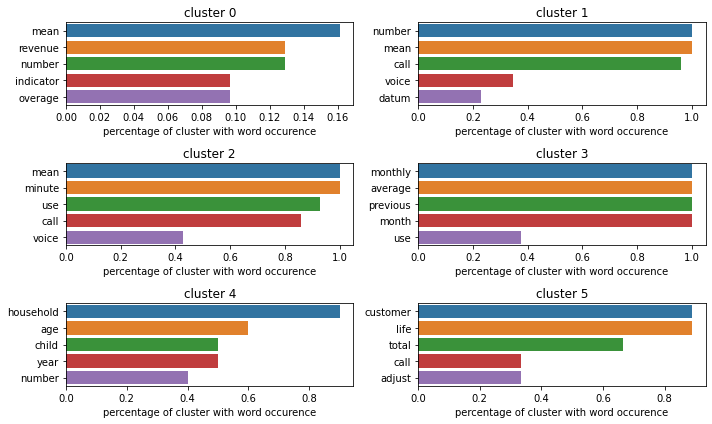

In [24]:
graph_all_cluster_wc(col_desc,'kmeans_class',figsize=(10,6))

We can also use T-SNE with default parameters to reduce our high dimensional dataset to two dimensions, so that we may graph our clusters for a quick sanity check. If the graph shows relatively clear demarcation of clusters, it means our "most common word" analysis from before actually represent each cluster well. If certain clusters do not have clear demarcations, we may need to double check that the clusters should actually be separated, and our K-Means didn't make a mistake. 

In [21]:
from sklearn.manifold import TSNE

In [22]:
tsne = TSNE(n_components=2,
            perplexity = 30,
            learning_rate='auto',
            init='pca',
            random_state=RANDOM_SEED)
tsneX = tsne.fit_transform(tfidfMatrix.toarray())

C:\Users\j3ff1\.conda\envs\xgboost\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


It seems like clusters 1 and 2 have very similar descriptions as their datapoints are pretty intermingled, while the other clusters all have relatively more clearly defined clusters. We should double check that cluster 1 and 2 actually contain descriptions of different topics, and our K-Means didn't separate the descriptions within these two clusters due to some mathematical quirk

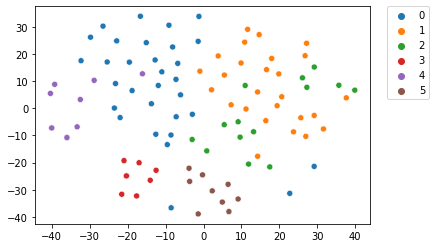

In [27]:
sns.scatterplot(
    x=tsneX[:,0],y=tsneX[:,1],hue=col_desc['kmeans_class'],
    palette=sns.color_palette("tab10")[:col_desc['kmeans_class'].nunique()]
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

create a list of clustered column names for easier access and examination

In [20]:
def get_clusters_list()->list:
    """returns a list where index corresponds
    to cluster id from kmeans clustering
    """
    clusters = []
    for cluster_id in np.sort(col_desc['kmeans_class'].unique()):
        clusters.append(
            col_desc[col_desc['kmeans_class']==cluster_id].index
        )
    return clusters

def get_col_desc(col_name:Union[str,List[str]])->Union[str,List[str]]:
    """get column description from column name
    """
    return col_desc.loc[col_name]['col_desc']

In [21]:
clusters = get_clusters_list()

We randomly sample 5 descriptions from each cluster to avoid being overwhelmed. From these samples, we see:
- Cluster 1 does indeed deal with general call statistics, while cluster 2 deals with statistics related to minutes.
- The reason the two clusters are so similar is because they both deal with a variety of similar statistics, but one breaks down said statistics by calls while the other by minutes. Hence, the K-Means was right to cluster them this way.

In [22]:
get_col_desc(clusters[1]).sample(n=5,random_state=RANDOM_SEED)

da_mean             Mean number of directory assisted calls
blck_dat_mean    Mean number of blocked (failed) data calls
comp_vce_mean          Mean number of completed voice calls
recv_vce_mean           Mean number of received voice calls
attempt_mean                Mean number of attempted calls 
Name: col_desc, dtype: object

In [23]:
get_col_desc(clusters[2]).sample(n=5,random_state=RANDOM_SEED)

mou_cvce_mean    Mean unrounded minutes of use of completed voi...
cc_mou_mean      Mean unrounded minutes of use of customer care...
ovrmou_mean                            Mean overage minutes of use
mou_mean                     Mean number of monthly minutes of use
inonemin_mean    Mean number of inbound calls less than one minute
Name: col_desc, dtype: object

Lastly, a quick look at cluster 0 does confirm our early suspicion that it is a collection of disparate column descriptions

In [24]:
get_col_desc(clusters[0]).sample(n=5,random_state=RANDOM_SEED)

datovr_mean                Mean revenue of data overage
refurb_new                  Handset: refurbished or new
rev_mean           Mean monthly revenue (charge amount)
dualband                                       Dualband
iwylis_vce_mean                                       N
Name: col_desc, dtype: object

# EDA

In [25]:
from JeffUtils import jeff_histplot

## Missing values

First we take a look at what values may be missing from our data

In [30]:
import networkx as nx

In [26]:
percentage_na = (raw_data.isna().sum().sort_values(ascending=False)/raw_data.shape[0])

(0.0, 5.0)

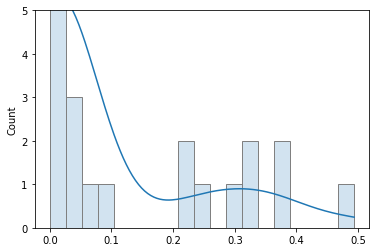

In [37]:
ax = jeff_histplot(percentage_na[percentage_na>0],kde=True)
ax.set_ylim(0,5)

## Finding columns with whose missingness is perfectly correlated

Lets take a look at columns that have a perfectly correlated missing values (i.e if one feature in the group has missing value, the rest would also for that row). 

In [27]:
#get the correlation of missing values between every column
mia_corr = raw_data.isna().corr()

In [28]:
perf_corr_cols = (
    mia_corr
    #Since (col1,col2) shows the same relationship as (col2,col1), 
    #and the diagonal will always be perfectly correlated,
    #we just need the upper triangular of the missing matrix
    .where(np.triu(np.ones(mia_corr.shape),1).astype(bool))
    #get columns whose missingness is perfectly correlated 
    .where(mia_corr==1,np.nan)
    #turn into list of tuples
    .stack().index
)

In [63]:
#create an undirected graph from the data with each column as a node
G = nx.from_pandas_edgelist(perf_corr_cols.to_frame().reset_index(drop=True),0,1)
perf_miss_cols = []

#add each component to a list for easier access
for c in nx.connected_components(G):
    perf_miss_cols.append(c)

Here we see the groups of columns who have perfectly correlated missingness. This means that for each row in our data, if that row has a column with a missing value, all other columns from the same group would also have a missing value in that row as well.

- The first missing group makes sense as it likely indicates the customer has just signed up within the last 6 months, hence cannot calculate average statistics for the last 6 months
- The second group 

In [72]:
get_col_desc(['change_mou','change_rev'])

change_mou    Percentage change in monthly minutes of use vs...
change_rev     Percentage change in monthly revenue vs previ...
Name: col_desc, dtype: object

In [67]:
for c in perf_miss_cols:
    print(c)

{'avg6qty', 'avg6mou', 'avg6rev'}
{'change_mou', 'change_rev'}
{'kid3_5', 'kid11_15', 'marital', 'kid16_17', 'kid6_10', 'rv', 'kid0_2', 'ethnic', 'creditcd', 'truck', 'forgntvl'}
{'ovrmou_mean', 'vceovr_mean', 'ovrrev_mean', 'mou_mean', 'roam_mean', 'rev_mean', 'da_mean', 'totmrc_mean', 'datovr_mean'}
{'phones', 'models', 'dualband', 'eqpdays', 'refurb_new'}


## Correlations

Lets take a look at absolute correlation values to see if any particular column already has a high predictive value on churn by itself

In [482]:
corrs = raw_data.corr()
churn_corrs = corrs['churn']

Below we see that most of the columns having low correlation values, hence it doesn't seem like any particular column has high predictive power by itself

<AxesSubplot:xlabel='churn', ylabel='Count'>

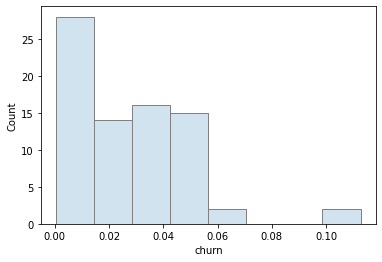

In [483]:
#remove first element since it'll be churn's correlation with itself 
sorted_abs_corr = abs(churn_corrs).sort_values(ascending=False)[1:]
jeff_histplot(sorted_abs_corr) 

It looks like the eqpdays and hnd_price columns have the highest correlation with churn. We'll take a look at these individually

In [471]:
sorted_abs_corr.head(5)

eqpdays          0.112691
hnd_price        0.103184
totmrc_mean      0.068558
mou_mean         0.057027
mou_cvce_mean    0.052042
Name: churn, dtype: float64

Seems like the longer you've been using the same equiment, the more likely you are going to churn

In [476]:
get_col_desc('eqpdays'),churn_corrs['eqpdays']

('Number of days (age) of current equipment', 0.11269140152670142)

Seems like the more expensive the phone your plan is tied to, the less likely you are to churn

In [478]:
get_col_desc('hnd_price'),churn_corrs['hnd_price']

('Current handset price', -0.10318395803125995)

# Categorical Column Examination